# Further Analysis

This notebook contains
- necessary imports
- similarity measures for distributions
- clustering methods
- attributions methods
- EOC measuring

In [1]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import random

In [2]:
# load 2 sign distributions

cifar_imp_0_sign_distr = pd.read_csv('2b Sign distributions/CIFAR_IMP_0_sign_distr.csv')
cifar_imp_1_sign_distr = pd.read_csv('2b Sign distributions/CIFAR_IMP_1_sign_distr.csv')
random_sign_distr = pd.read_csv('2b Sign distributions/RSN_0_sign_distr.csv')
cifar_imp_0_sign_distr.head() 

,pos_in,pos_out,neg_in,neg_out,prune_rate_in,prune_rate_out,sign_rate_in,sign_rate_out,layer
0,794,96,625,104,0.913391,0.218750,0.559549,0.480000,dense1
1,912,102,870,96,0.891235,0.226562,0.511785,0.515152,dense1
2,938,81,858,111,0.890381,0.250000,0.522272,0.421875,dense1
3,756,100,620,74,0.916016,0.320312,0.549419,0.574713,dense1
4,402,86,426,79,0.949463,0.355469,0.485507,0.521212,dense1


In [3]:
# two numpy arrays of the same variable

array1 = np.array(cifar_imp_0_sign_distr[cifar_imp_0_sign_distr["layer"]=="dense2"][["sign_rate_out"]])
array2 = np.array(cifar_imp_1_sign_distr[cifar_imp_1_sign_distr["layer"]=="dense2"][["sign_rate_out"]])
array3 = np.array(random_sign_distr[random_sign_distr["layer"]=="dense2"][["sign_rate_out"]])

In [4]:
# function to turn it into discrete probability distributions

def make_prob_distr(array1, array2):

    union = []
    union.extend(array1.flat)
    union.extend(array2.flat)
    unique_values = list(set(union))
    unique_values.sort()

    probdistr1 = []
    probdistr2 = []
    for v in unique_values:
        probdistr1.append((array1 == v).sum()/len(array1.flat))
        probdistr2.append((array2 == v).sum()/len(array2.flat))
        
    return probdistr1, probdistr2

# KL Divergence

In [5]:
# calculate KL divergence

def kl_divergence(array1, array2):
    l_sum = [0.0]
    for p,q in zip(array1, array2):
        if p*q != 0.0:
            l_sum.append(p * np.log(p / q))
    return np.sum(l_sum)

def make_prob_and_kl_divergence(array1, array2):
    probdistr1, probdistr2 = make_prob_distr(array1, array2)
    return kl_divergence(probdistr1, probdistr2)

In [6]:
print("both WT arrays: ")
print(make_prob_and_kl_divergence(array1, array2))
print(make_prob_and_kl_divergence(array2, array1))
print("identical arrays: ")
print(make_prob_and_kl_divergence(array1, array1))
print(make_prob_and_kl_divergence(array2, array2))
print("WT with random array: ")
print(make_prob_and_kl_divergence(array2, array3))
print(make_prob_and_kl_divergence(array3, array2))
print(make_prob_and_kl_divergence(array1, array3))
print(make_prob_and_kl_divergence(array3, array1))

both WT arrays: 
0.07817968809312958
0.04391229440874625
identical arrays: 
0.0
0.0
WT with random array: 
0.05907297450820153
0.07445340982171182
0.08780715692385113
0.07291807498274293


In [7]:
def get_sign_dist(n, p_type):
    sign_distr = pd.read_csv(f'2b Sign distributions/{p_type}_{n}_sign_distr.csv')
    return np.array(sign_distr[sign_distr["layer"]=="dense1"][["sign_rate_in"]])

In [8]:
kl_random = []
kl_mixed = []
kl_wt = []

# taking pairs, both ways
for i in range(10):
    for j in range(10):
        if i != j:
            wt1 = get_sign_dist(i, "CIFAR_IMP")
            wt2 = get_sign_dist(j, "CIFAR_IMP")
            rand1 = get_sign_dist(i, "RSN")
            rand2 = get_sign_dist(j, "RSN")
            kl_random.append(make_prob_and_kl_divergence(rand1,rand2))
            kl_mixed.append(make_prob_and_kl_divergence(wt1,rand1))
            kl_wt.append(make_prob_and_kl_divergence(wt1,wt2))

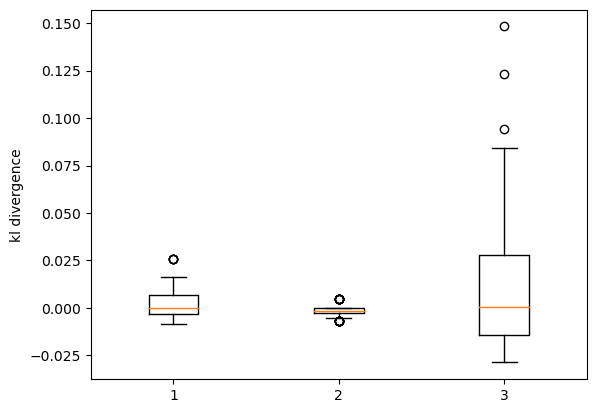

In [9]:
fig, ax = plt.subplots()
ax.set_ylabel('kl divergence')
bplot = ax.boxplot([kl_random, kl_mixed, kl_wt])
                   #tick_labels=["kl_random","kl_mixed","kl_WT"])  # will be used to label x-ticks
plt.show()

# JS Divergence

In [10]:
# jason shanon divergence

def make_mixture_distribution(array1, array2):
    
    union = []
    union.extend(array1.flat)
    union.extend(array2.flat)
    unique_values = list(set(union))
    unique_values.sort()

    probdistr = []
    for v in unique_values:
        probdistr1 = (array1 == v).sum() / len(array1.flat)
        probdistr2 = (array2 == v).sum() / len(array2.flat)
        probdistr.append(np.mean([probdistr1,probdistr2]))
        
    return probdistr

def js_divergence(array1, array2):
    
    probdistr1, probdistr2 = make_prob_distr(array1, array2)
    mix_prob_distr = make_mixture_distribution(array1, array2)
    js = 0.5*kl_divergence(probdistr1, mix_prob_distr) + 0.5*kl_divergence(probdistr2, mix_prob_distr)
                          
    return js                          

In [11]:
print("both WT arrays: ")
print(js_divergence(array1, array2))
print(js_divergence(array2, array1))
print("identical arrays: ")
print(js_divergence(array1, array1))
print(js_divergence(array2, array2))
print("WT with random array: ")
print(js_divergence(array2, array3))
print(js_divergence(array3, array2))
print(js_divergence(array1, array3))
print(js_divergence(array3, array1))

both WT arrays: 
0.027069751988434254
0.027069751988434254
identical arrays: 
0.0
0.0
WT with random array: 
0.04199146601794272
0.04199146601794272
0.05884171303436102
0.05884171303436102


In [12]:
def get_sign_dist(n, p_type):
    sign_distr = pd.read_csv(f'2b Sign distributions/{p_type}_{n}_sign_distr.csv')
    return np.array(sign_distr[sign_distr["layer"]=="dense1"][["prune_rate_in"]])

In [13]:
kl_random = []
kl_mixed = []
kl_wt = []

# taking pairs, but not both ways
for i in range(10):
    for j in range(10):
        if i < j:
            wt1 = get_sign_dist(i, "CIFAR_IMP")
            wt2 = get_sign_dist(j, "CIFAR_IMP")
            rand1 = get_sign_dist(i, "RSN")
            rand2 = get_sign_dist(j, "RSN")
            kl_random.append(js_divergence(rand1,rand2))
            kl_mixed.append(js_divergence(wt1,rand1))
            kl_wt.append(js_divergence(wt1,wt2))

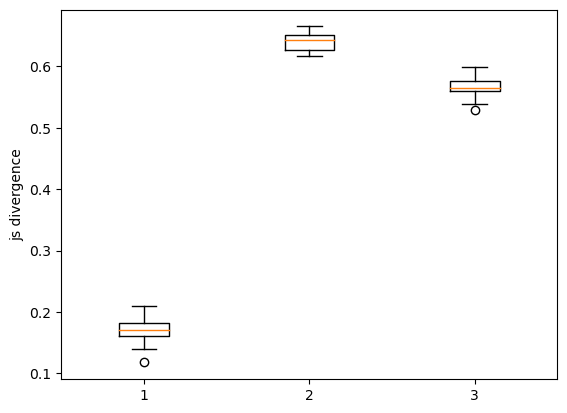

In [14]:
fig, ax = plt.subplots()
ax.set_ylabel('js divergence')
bplot = ax.boxplot([kl_random, kl_mixed, kl_wt])
                   #tick_labels=["kl_random","kl_mixed","kl_WT"])  # will be used to label x-ticks
plt.show()

# Wasserstein distance

In [15]:
#scipy.stats.wasserstein_distance(u_values, v_values, u_weights=None, v_weights=None)[source]

def wasserstein_distance(array1, array2):
    
    union = []
    union.extend(array1.flat)
    union.extend(array2.flat)
    unique_values = list(set(union))
    unique_values.sort()

    probdistr1 = []
    probdistr2 = []
    for v in unique_values:
        probdistr1.append((array1 == v).sum()/len(array1.flat))
        probdistr2.append((array2 == v).sum()/len(array2.flat))

    return scipy.stats.wasserstein_distance(u_values=probdistr1, v_values=probdistr2, u_weights=unique_values, v_weights=unique_values)

In [16]:
print("both WT arrays: ")
print(wasserstein_distance(array1, array2))
print(wasserstein_distance(array2, array1))
print("identical arrays: ")
print(wasserstein_distance(array1, array1))
print(wasserstein_distance(array2, array2))
print("WT with random array: ")
print(wasserstein_distance(array2, array3))
print(wasserstein_distance(array3, array2))
print(wasserstein_distance(array1, array3))
print(wasserstein_distance(array3, array1))

both WT arrays: 
0.006321609522987018
0.006321609522987018
identical arrays: 
0.0
0.0
WT with random array: 
0.0072092613927291355
0.0072092613927291355
0.006577190170940172
0.006577190170940172


In [17]:
def get_sign_dist(n, p_type):
    sign_distr = pd.read_csv(f'2b Sign distributions/{p_type}_{n}_sign_distr.csv')
    return np.array(sign_distr[sign_distr["layer"]=="dense1"][["sign_rate_in"]])

In [18]:
kl_random = []
kl_mixed = []
kl_wt = []

# taking pairs, but not both ways
for i in range(10):
    for j in range(10):
        if i < j:
            wt1 = get_sign_dist(i, "CIFAR_IMP")
            wt2 = get_sign_dist(j, "CIFAR_IMP")
            rand1 = get_sign_dist(i, "RSN")
            rand2 = get_sign_dist(j, "RSN")
            kl_random.append(wasserstein_distance(rand1,rand2))
            kl_mixed.append(wasserstein_distance(wt1,rand1))
            kl_wt.append(wasserstein_distance(wt1,wt2))

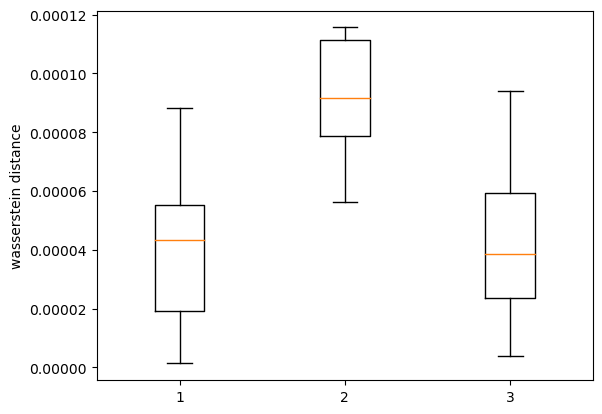

In [19]:
fig, ax = plt.subplots()
ax.set_ylabel('wasserstein distance')
bplot = ax.boxplot([kl_random, kl_mixed, kl_wt])
                   #tick_labels=["kl_random","kl_mixed","kl_WT"])  # will be used to label x-ticks
plt.show()

# Bhattacharyya distance

In [20]:
def bhattacharyya(array1, array2):
    
    probdistr1, probdistr2 = make_prob_distr(array1, array2)
    bc = np.sum(np.sqrt(np.multiply(probdistr1, probdistr2)))                    
    return - np.log(bc) 

In [21]:
print("both WT arrays: ")
print(bhattacharyya(array1, array2))
print(bhattacharyya(array2, array1))
print("identical arrays: ")
print(bhattacharyya(array1, array1))
print(bhattacharyya(array2, array2))
print("WT with random array: ")
print(bhattacharyya(array2, array3))
print(bhattacharyya(array3, array2))
print(bhattacharyya(array1, array3))
print(bhattacharyya(array3, array1))

both WT arrays: 
0.03319261812104279
0.03319261812104279
identical arrays: 
-0.0
-0.0
WT with random array: 
0.05507310527846157
0.05507310527846157
0.0795527452841903
0.0795527452841903


In [22]:
def get_sign_dist(n, p_type):
    sign_distr = pd.read_csv(f'2b Sign distributions/{p_type}_{n}_sign_distr.csv')
    return np.array(sign_distr[sign_distr["layer"]=="dense2"][["sign_rate_in"]])

In [23]:
kl_random = []
kl_mixed = []
kl_wt = []

# taking pairs, but not both ways
for i in range(10):
    for j in range(10):
        if i < j:
            wt1 = get_sign_dist(i, "CIFAR_IMP")
            wt2 = get_sign_dist(j, "CIFAR_IMP")
            rand1 = get_sign_dist(i, "RSN")
            rand2 = get_sign_dist(j, "RSN")
            kl_random.append(bhattacharyya(rand1,rand2))
            kl_mixed.append(bhattacharyya(wt1,rand1))
            kl_wt.append(bhattacharyya(wt1,wt2))

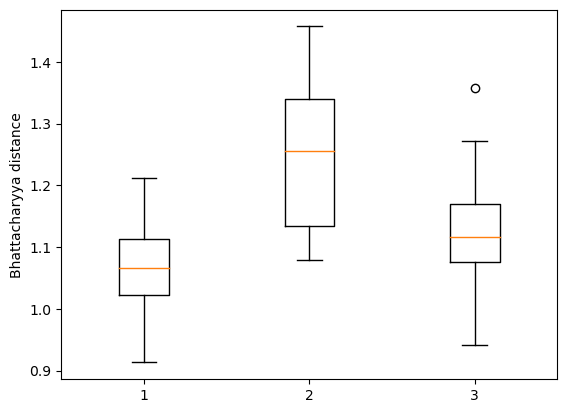

In [24]:
fig, ax = plt.subplots()
ax.set_ylabel('Bhattacharyya distance')
bplot = ax.boxplot([kl_random, kl_mixed, kl_wt])
                   #tick_labels=["kl_random","kl_mixed","kl_WT"])  # will be used to label x-ticks
plt.show()

# Hellinger distance

In [25]:
def hellinger_distance(array1, array2):
    
    probdistr1, probdistr2 = make_prob_distr(array1, array2)
    bc = np.sum(np.sqrt(np.multiply(probdistr1, probdistr2)))                    
    return np.sqrt(1-bc) 

In [26]:
print("both WT arrays: ")
print(hellinger_distance(array1, array2))
print(hellinger_distance(array2, array1))
print("identical arrays: ")
print(hellinger_distance(array1, array1))
print(hellinger_distance(array2, array2))
print("WT with random array: ")
print(hellinger_distance(array2, array3))
print(hellinger_distance(array3, array2))
print(hellinger_distance(array1, array3))
print(hellinger_distance(array3, array1))

both WT arrays: 
0.18068698880335166
0.18068698880335166
identical arrays: 
0.0
0.0
WT with random array: 
0.23148227270719818
0.23148227270719818
0.2765333490409869
0.2765333490409869


In [30]:
def get_sign_dist(n, p_type):
    sign_distr = pd.read_csv(f'2b Sign distributions/{p_type}_{n}_sign_distr.csv')
    return np.array(sign_distr[sign_distr["layer"]=="dense1"][["prune_rate_in"]])

In [31]:
kl_random = []
kl_mixed = []
kl_wt = []

# taking pairs, but not both ways
for i in range(10):
    for j in range(10):
        if i < j:
            wt1 = get_sign_dist(i, "CIFAR_IMP")
            wt2 = get_sign_dist(j, "CIFAR_IMP")
            rand1 = get_sign_dist(i, "RSN")
            rand2 = get_sign_dist(j, "RSN")
            kl_random.append(bhattacharyya(rand1,rand2))
            kl_mixed.append(bhattacharyya(wt1,rand1))
            kl_wt.append(bhattacharyya(wt1,wt2))

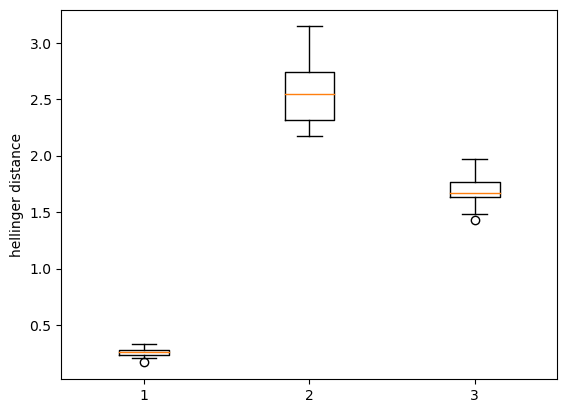

In [32]:
fig, ax = plt.subplots()
ax.set_ylabel('hellinger distance')
bplot = ax.boxplot([kl_random, kl_mixed, kl_wt])
                   #tick_labels=["kl_random","kl_mixed","kl_WT"])  # will be used to label x-ticks
plt.show()